<a href="https://colab.research.google.com/github/Armin-Abdollahi/Multilayer-Perceptron-Neural-Network/blob/main/TransferLearning_DatasetCustom_MLP_FineTune_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('../content/drive')

Mounted at ../content/drive


In [2]:
!unzip /content/drive/MyDrive/datasetCatDog.zip -d /content/drive/MyDrive/datasetCD

Archive:  /content/drive/MyDrive/datasetCatDog.zip
replace /content/drive/MyDrive/datasetCD/datasetCatDog/cat/cat.4001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

In [4]:
# Define data transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
# Load dataset
dataset = torchvision.datasets.ImageFolder(root="/content/drive/MyDrive/datasetCD", transform=data_transform)

In [6]:
# Define data loader
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Load pre-trained ResNet50 model
model = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


In [8]:
# Remove the last fully connected layer
model = torch.nn.Sequential(*list(model.children())[:-1])

In [9]:
# Set model to evaluation mode
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Extract features and labels
features_list = []
labels_list = []

with torch.no_grad():
    for images, labels in data_loader:
        images = images.to(device)
        features = model(images)
        features_list.append(features.cpu().numpy())
        labels_list.append(labels.numpy())

In [12]:
# Concatenate features and labels
features = torch.from_numpy(np.concatenate(features_list))
labels = torch.from_numpy(np.concatenate(labels_list))

In [13]:
# Flatten features
features = features.view(features.size(0), -1)

In [14]:
# Create pandas DataFrame
df = pd.DataFrame(features.numpy())

In [15]:
# Get folder names to assign labels (0 for 'cat' and 1 for 'dog')
folder_names = dataset.classes

numerical_labels = [0 if folder == 'cat' else
                    1 if folder == 'dog' else
                    2 for folder in folder_names]

In [16]:
# Assign labels to the DataFrame
df['label'] = [numerical_labels[label] for label in labels]

In [17]:
# Save DataFrame to Excel
df.to_excel('cat_dog_dataset.xlsx', index=False)

In [18]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load Iris dataset from Excel file
data_df = pd.read_excel('/content/cat_dog_dataset.xlsx')
X = data_df.iloc[:, :-1].values
y = data_df.iloc[:, -1].values


print(X.shape)
print(y.shape)

print(X)
print(y)



(385, 2048)
(385,)
[[1.07547724 0.26757732 0.56727064 ... 0.59419024 0.62411839 0.21950956]
 [1.09955204 1.05143523 0.88173252 ... 0.4402414  0.82058489 0.36509505]
 [0.7531538  0.43103766 0.34460071 ... 0.58269083 0.23481803 0.27600566]
 ...
 [0.57300931 0.49868712 0.52697837 ... 0.92552638 0.47917256 0.1009163 ]
 [0.12977655 0.3750518  0.09129623 ... 0.07182819 0.20655768 0.44055569]
 [0.85971528 0.12490003 0.36812925 ... 0.4222621  0.09254449 0.18261674]]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2

In [19]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [20]:
# Load dataset from Excel file
data_df = pd.read_excel('/content/cat_dog_dataset.xlsx')
X = data_df.iloc[:, :-1].values
y = data_df.iloc[:, -1].values

In [21]:
# Apply Min-Max scaling
print(X.shape)
print(y.shape)

(385, 2048)
(385,)


In [22]:
# Apply Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [24]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [25]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=1)  # Apply softmax activation for multi-class classification

In [26]:
# Define training function
def train(model, criterion, optimizer, X_train, y_train, num_epochs=100):
    train_losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return train_losses

In [27]:
# Initialize the model, loss function, and optimizer
input_size = 2048
hidden_size1 = 100
hidden_size2 = 50
output_size = 3
model = MLP(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
# Train the model
train_losses = train(model, criterion, optimizer, X_train, y_train, num_epochs=1000)

Epoch [50/1000], Loss: 0.5514
Epoch [100/1000], Loss: 0.5514
Epoch [150/1000], Loss: 0.5514
Epoch [200/1000], Loss: 0.5514
Epoch [250/1000], Loss: 0.5514
Epoch [300/1000], Loss: 0.5514
Epoch [350/1000], Loss: 0.5514
Epoch [400/1000], Loss: 0.5514
Epoch [450/1000], Loss: 0.5514
Epoch [500/1000], Loss: 0.5514
Epoch [550/1000], Loss: 0.5514
Epoch [600/1000], Loss: 0.5514
Epoch [650/1000], Loss: 0.5514
Epoch [700/1000], Loss: 0.5514
Epoch [750/1000], Loss: 0.5514
Epoch [800/1000], Loss: 0.5514
Epoch [850/1000], Loss: 0.5514
Epoch [900/1000], Loss: 0.5514
Epoch [950/1000], Loss: 0.5514
Epoch [1000/1000], Loss: 0.5514


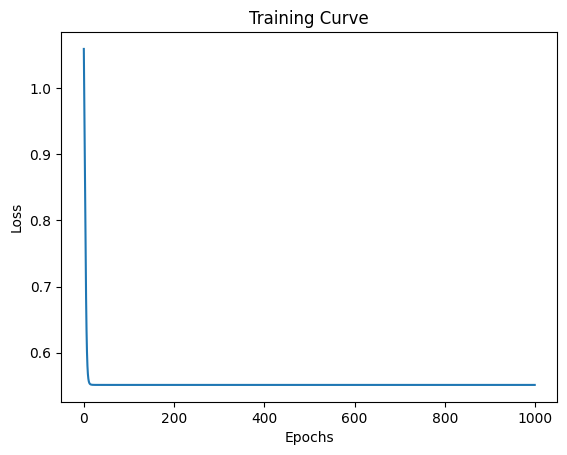

In [29]:
# Plot the training curve
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Curve')
plt.show()

In [30]:
# Predict classes for training set
with torch.no_grad():
    train_outputs = model(X_train)
    _, train_predicted = torch.max(train_outputs, 1)

In [31]:
# Calculate confusion matrix and accuracy for training set
train_cm = confusion_matrix(y_train.numpy(), train_predicted.numpy())
train_accuracy = accuracy_score(y_train.numpy(), train_predicted.numpy())

print("Training Confusion Matrix:")
print(train_cm)
print("Training Accuracy:", train_accuracy)

Training Confusion Matrix:
[[308]]
Training Accuracy: 1.0


In [32]:
# Predict classes for test set
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)

In [33]:
# Calculate confusion matrix and accuracy for test set
test_cm = confusion_matrix(y_test.numpy(), test_predicted.numpy())
test_accuracy = accuracy_score(y_test.numpy(), test_predicted.numpy())

In [34]:
print("\nTesting Confusion Matrix:")
print(test_cm)
print("Testing Accuracy:", test_accuracy)


Testing Confusion Matrix:
[[77]]
Testing Accuracy: 1.0


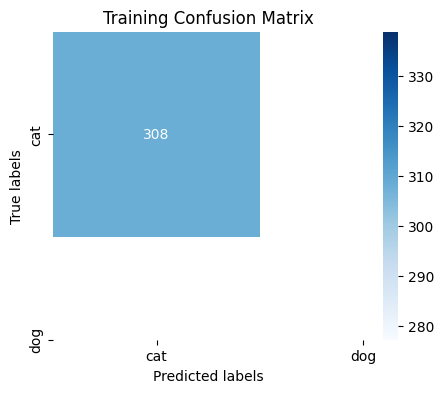

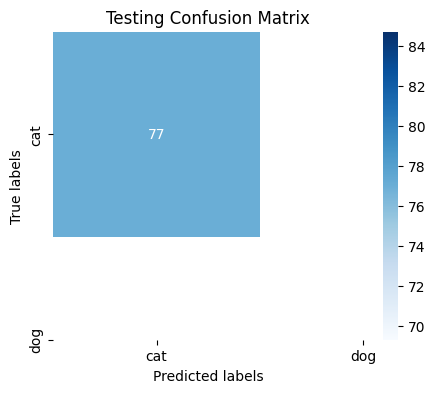

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes for training set
with torch.no_grad():
    train_outputs = model(X_train)
    _, train_predicted = torch.max(train_outputs, 1)

# Calculate confusion matrix for training set
train_cm = confusion_matrix(y_train.numpy(), train_predicted.numpy())

# Plot training confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Training Confusion Matrix')
plt.show()

# Predict classes for test set
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix for test set
test_cm = confusion_matrix(y_test.numpy(), test_predicted.numpy())

# Plot testing confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Testing Confusion Matrix')
plt.show()


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet50
from PIL import Image

In [37]:
# Define data transformations for the input image
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [38]:
# Load the trained ResNet model
resnet_model = resnet50(pretrained=True)
resnet_model.fc = nn.Identity()  # Remove the final fully connected layer

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
# Set models to evaluation mode
resnet_model.eval()

def extract_features(image_path, model):
    image = Image.open(image_path)
    image = data_transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(image)
    return features.flatten()

In [40]:
def predict_image(image_path, resnet_model):
    # Extract features using ResNet
    features = extract_features(image_path, resnet_model)
    features = torch.unsqueeze(features, dim=0)

    # Make prediction using MLP
    with torch.no_grad():
        output = model(features)

    _, predicted = torch.max(output, 1)

    # Convert numerical label to string label
    label = "cat" if predicted.item() == 0 else "dog"

    return label

In [41]:
# Input image path
image_path = '/content/drive/MyDrive/Dog_101.jpg'

In [42]:
# Predict the image
prediction = predict_image(image_path, resnet_model)
print("Prediction:", prediction)

Prediction: dog
